In [ ]:
# ResNet50 Testing

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
import torchvision.models as models

import cv2

import matplotlib.pyplot as plt
import numpy as np

import os

from dice_loss import DiceLoss
import torch.optim as optim
from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset

from transforms import BrainMRITransforms

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# batch
batch_size = 64

learning_rate = 0.0003

In [4]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

transform_ = BrainMRITransforms()

train_data = BrainMRIDataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = BrainMRIDataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = BrainMRIDataset(test_df, transform = transform_ ,  mask_transform= transform_)

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = False)


In [5]:
# ResNet50

class ResNet50Seg(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50Seg, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove the final fully connected layer and avgpool layer
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
model = ResNet50Seg().to(device)

/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 42909633
Trainable parameters: 42909633


In [8]:
# Load weights for parallel training
state_dict = torch.load('resnet50_weights.pth', map_location=device)
# Remove the 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Load state dict
model.load_state_dict(state_dict)
model.eval()

# ## Load weights
# model.load_state_dict(torch.load('resnet18_weights.pth'))
# model.eval()

ResNet50Seg(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [9]:

size_model = 0
for param in state_dict.values():
    if param.is_floating_point():
        size_model += param.numel() * torch.finfo(param.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

model size: 1374811488 / bit | 171.85 / MB


In [10]:
def visualize_sample(image, pred_mask, true_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot image
    axes[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot predicted mask
    axes[1].imshow(pred_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Plot true mask
    axes[2].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[2].set_title('True Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


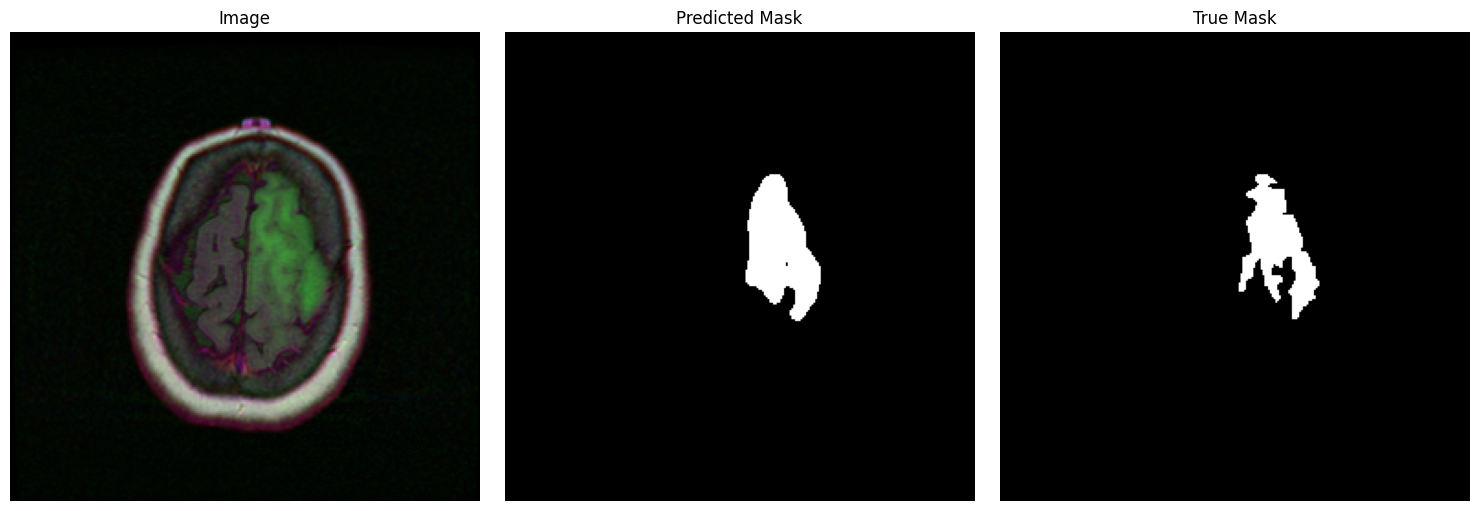

iou: 0.7292659878730774
dice: 0.8434399366378784


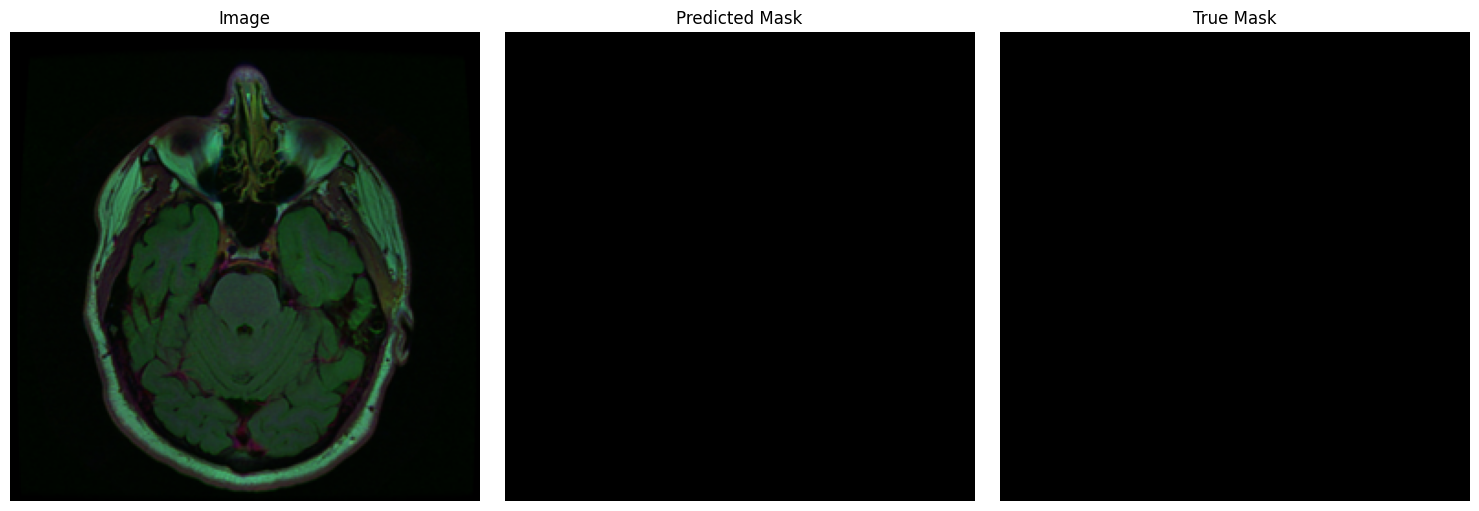

iou: 0.0
dice: nan


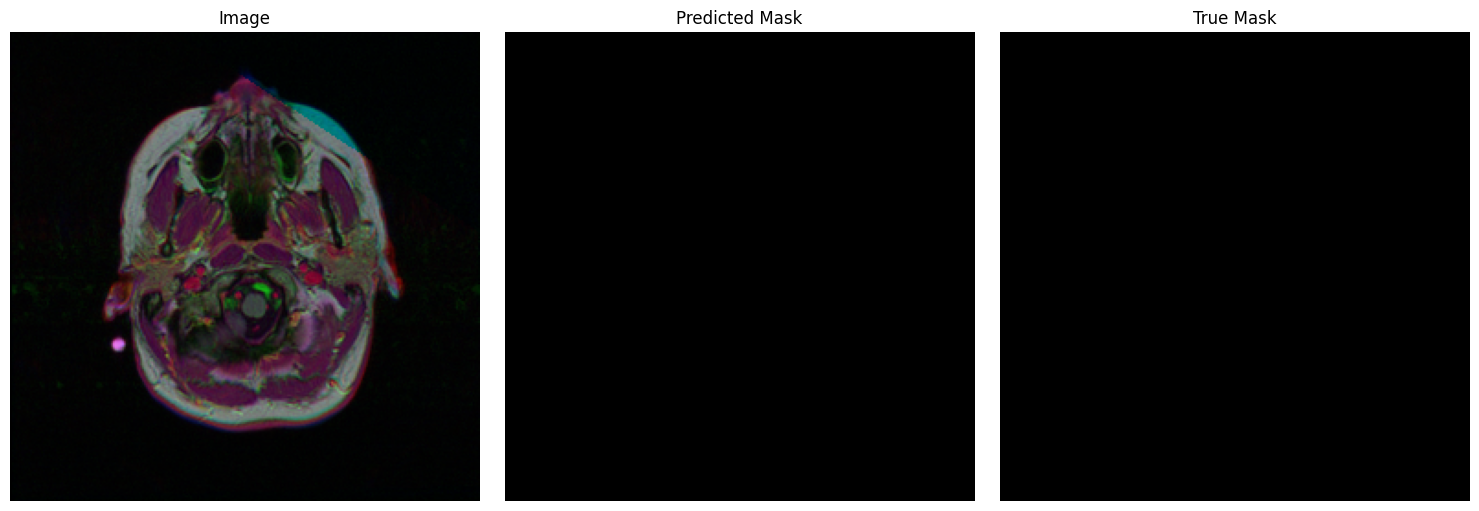

iou: 0.0
dice: nan


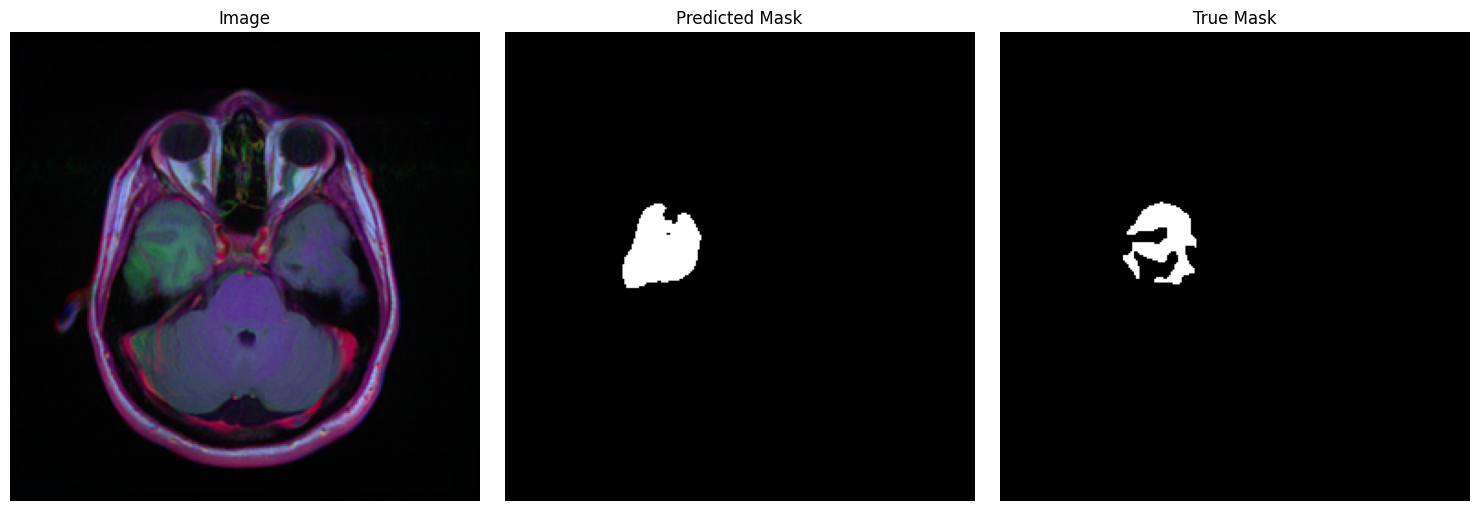

iou: 0.5142667293548584
dice: 0.6792287230491638


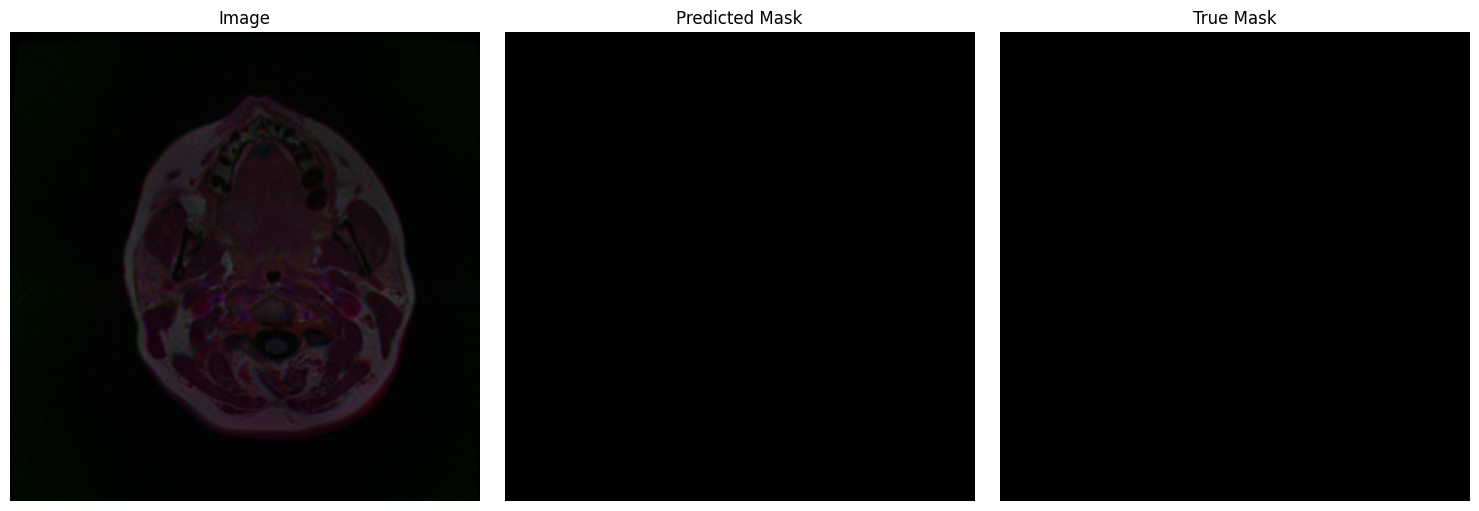

iou: 0.0
dice: nan


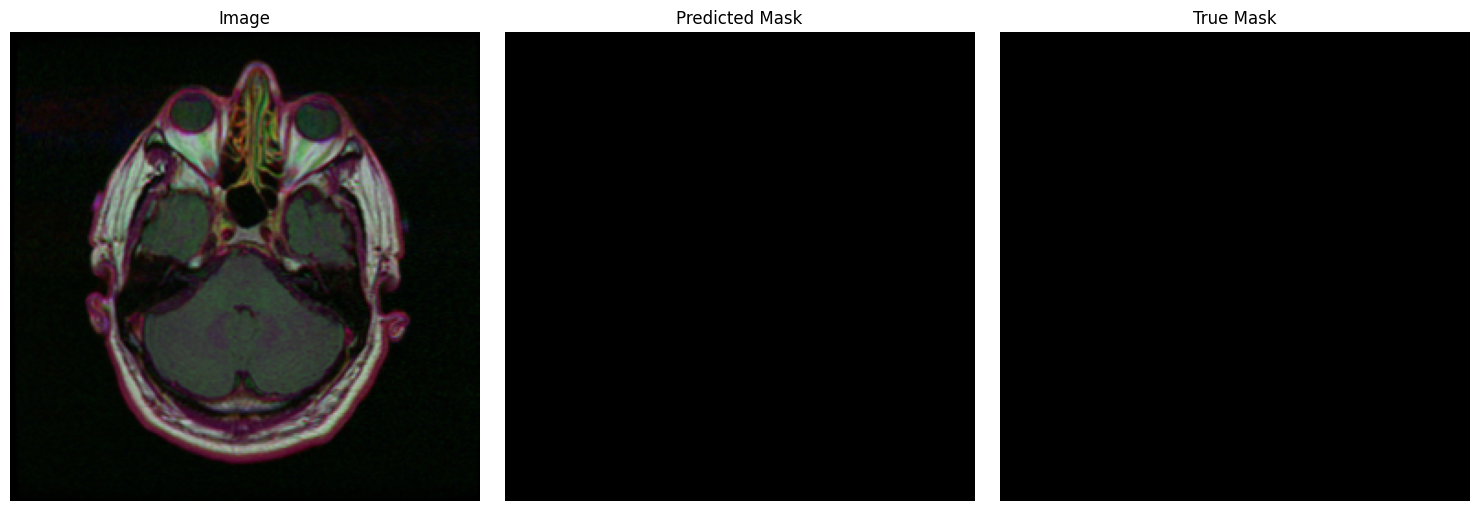

iou: 0.0
dice: nan


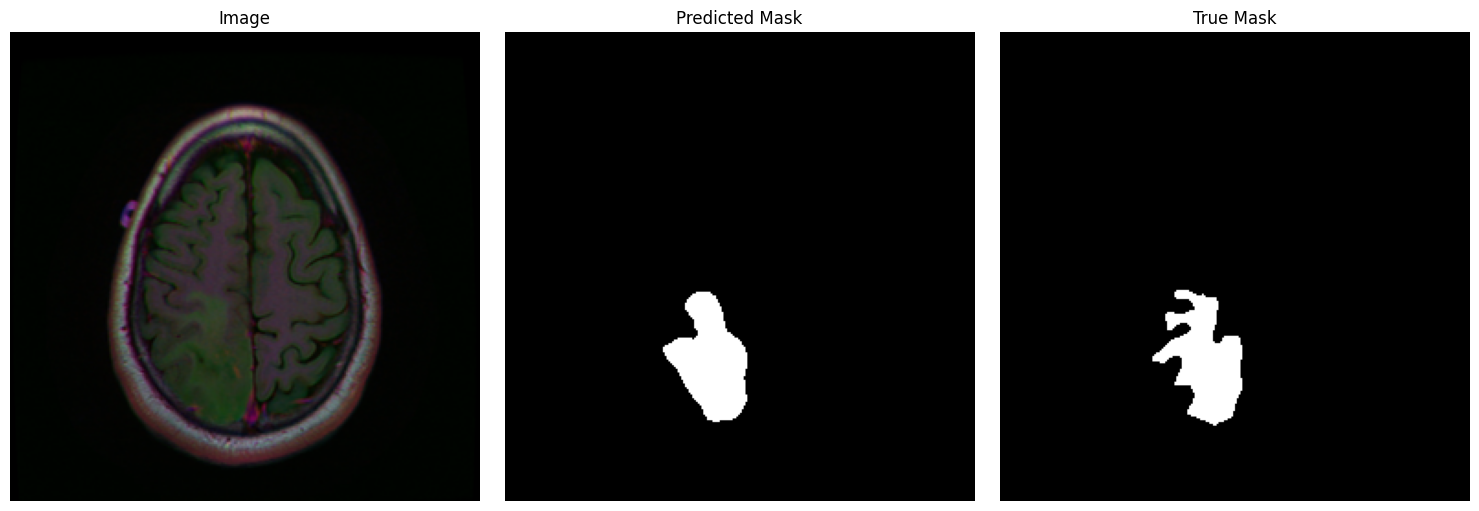

iou: 0.7652968168258667
dice: 0.867046058177948


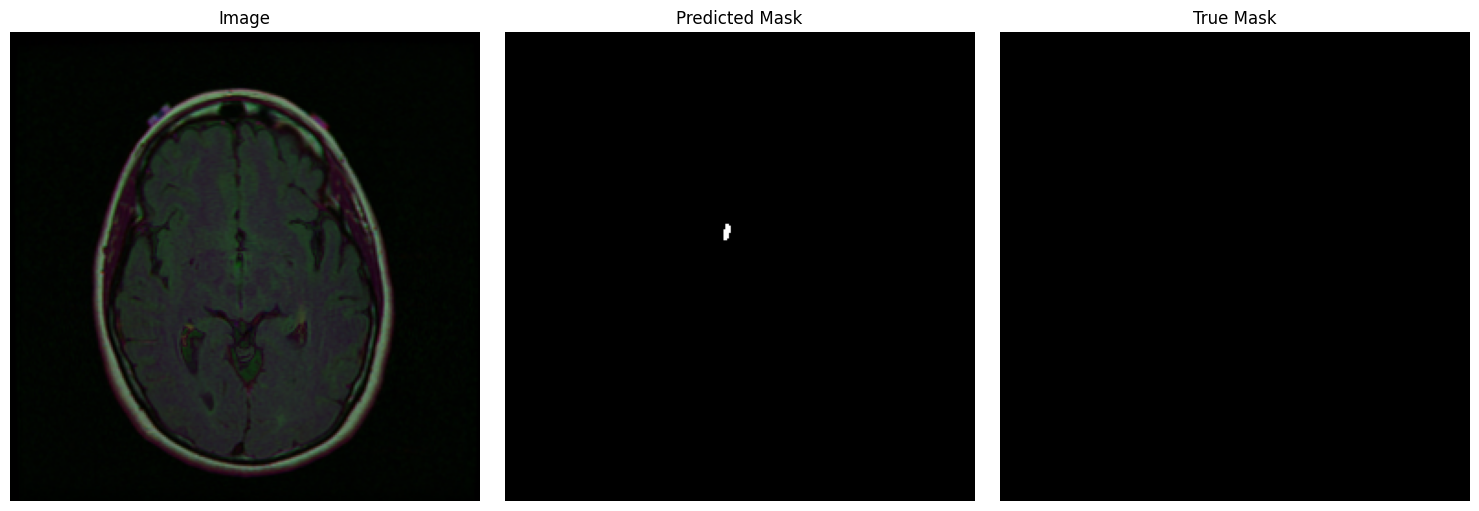

iou: 0.0
dice: 0.0


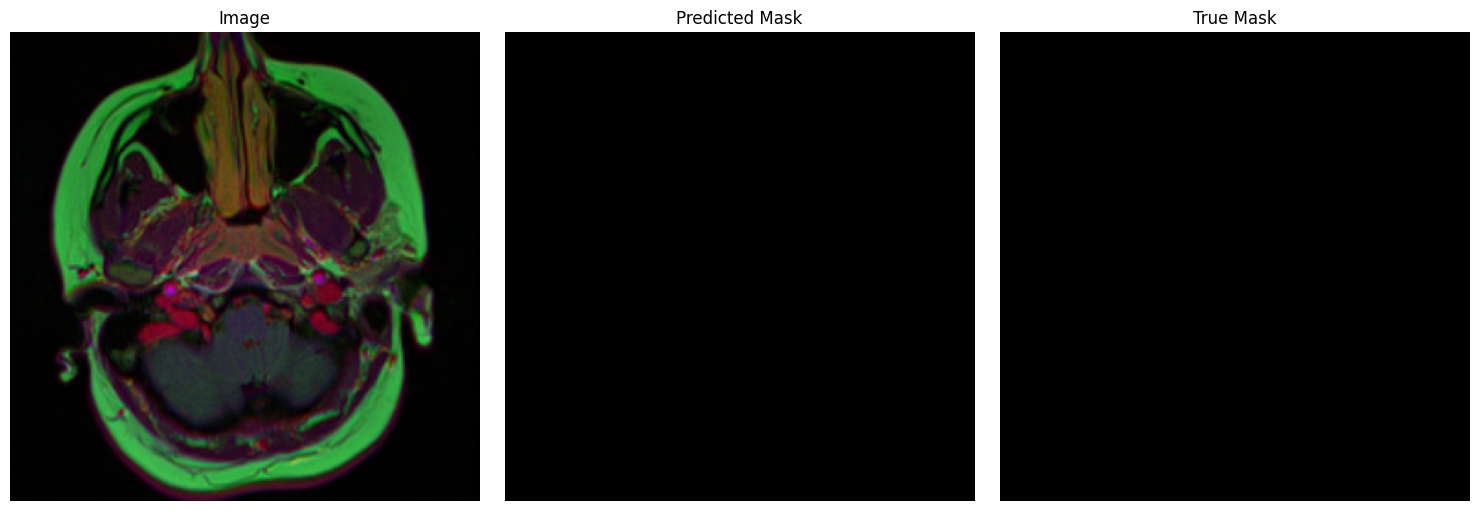

iou: 0.0
dice: nan


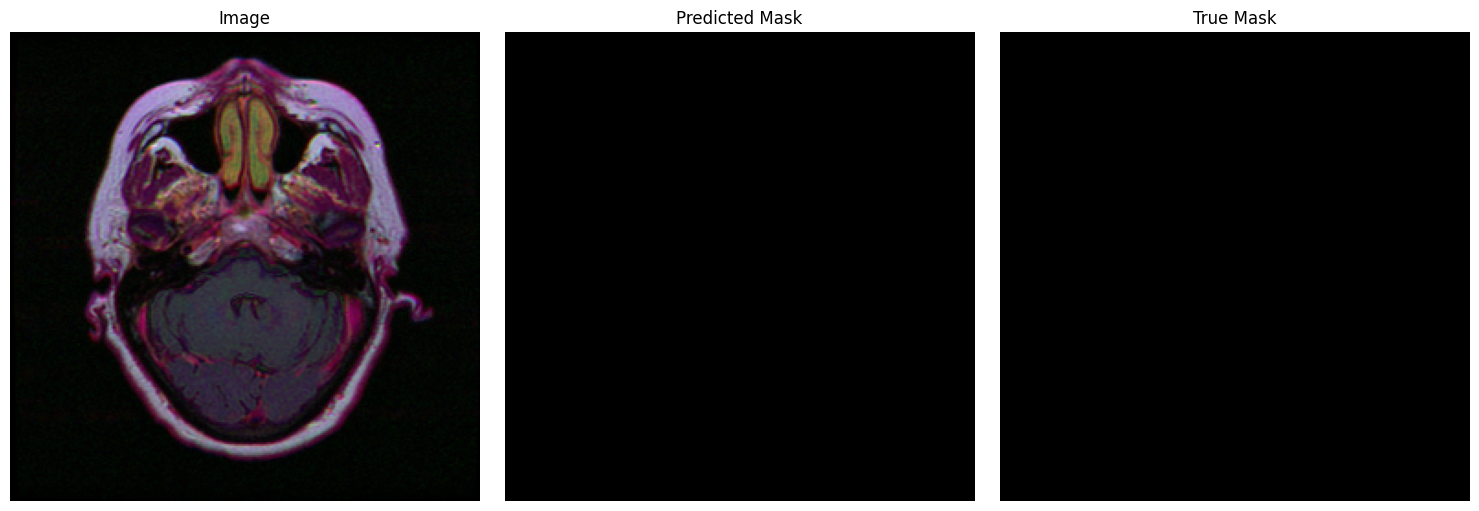

iou: 0.0
dice: nan


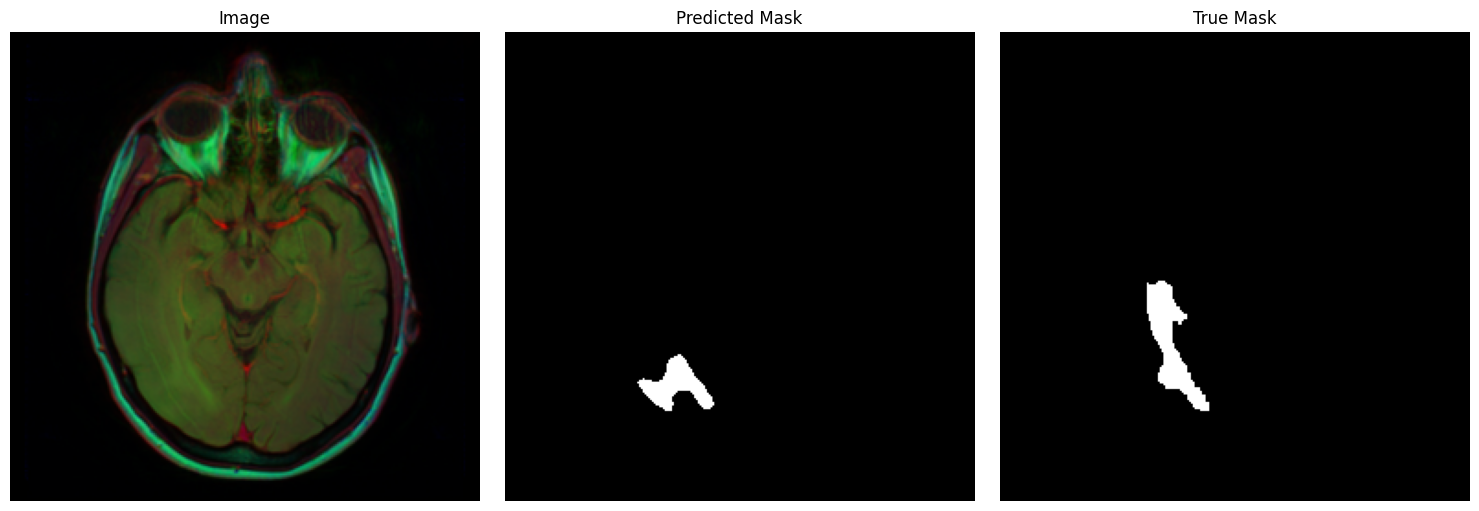

iou: 0.29870128631591797
dice: 0.46000000834465027


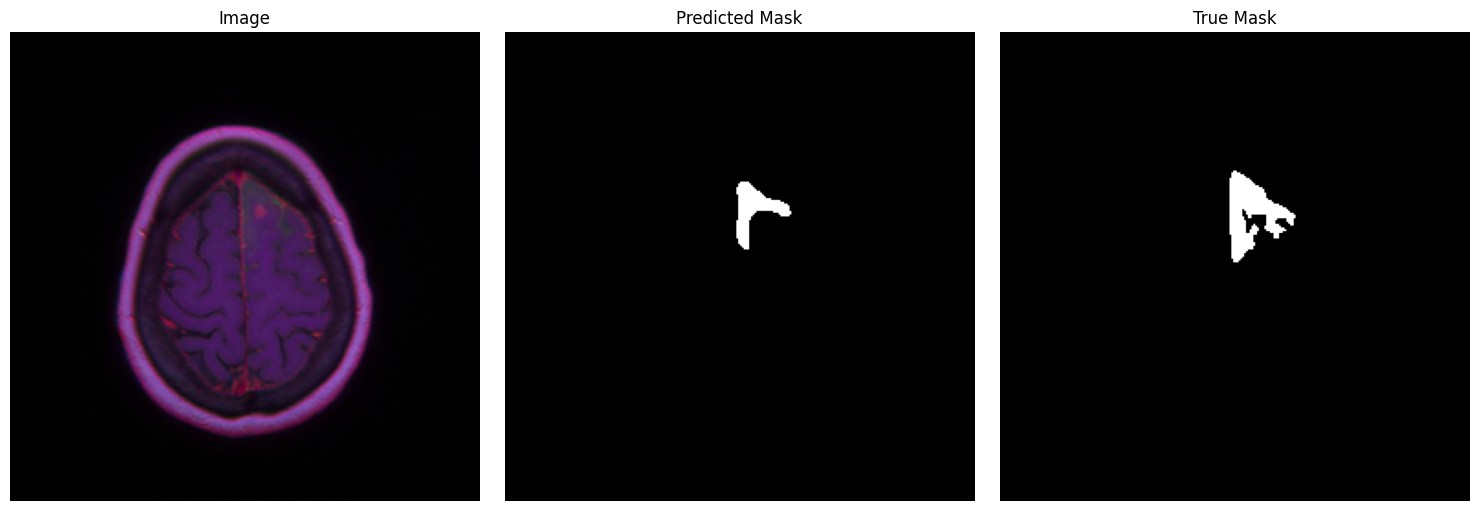

iou: 0.4923619329929352
dice: 0.6598424911499023


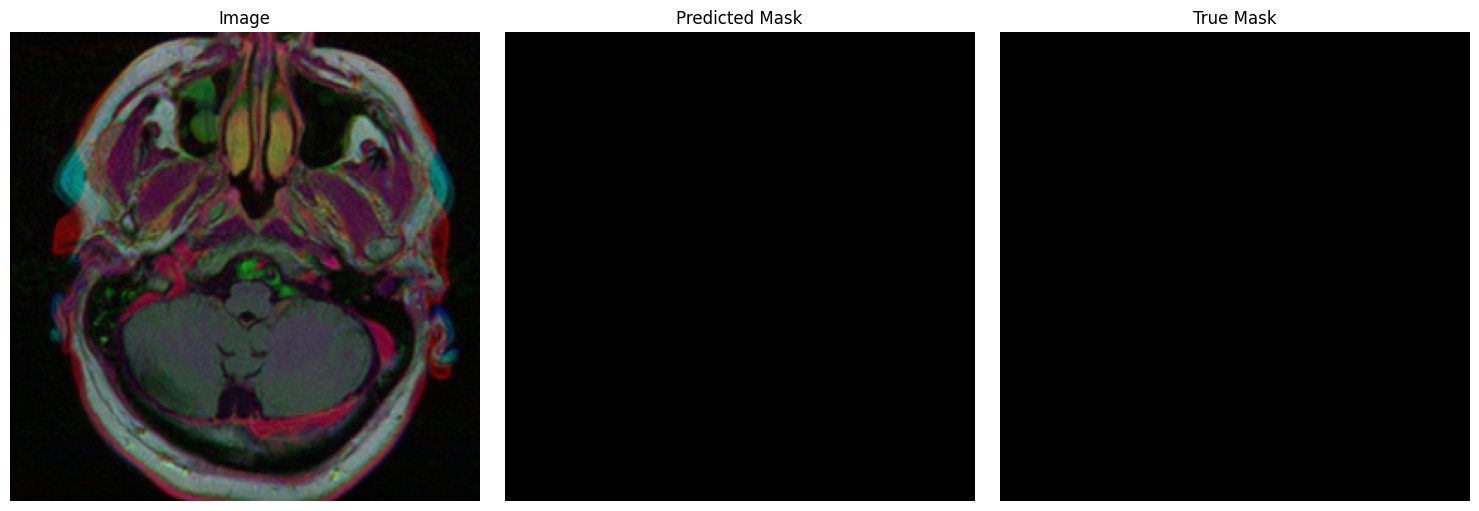

iou: 0.0
dice: nan


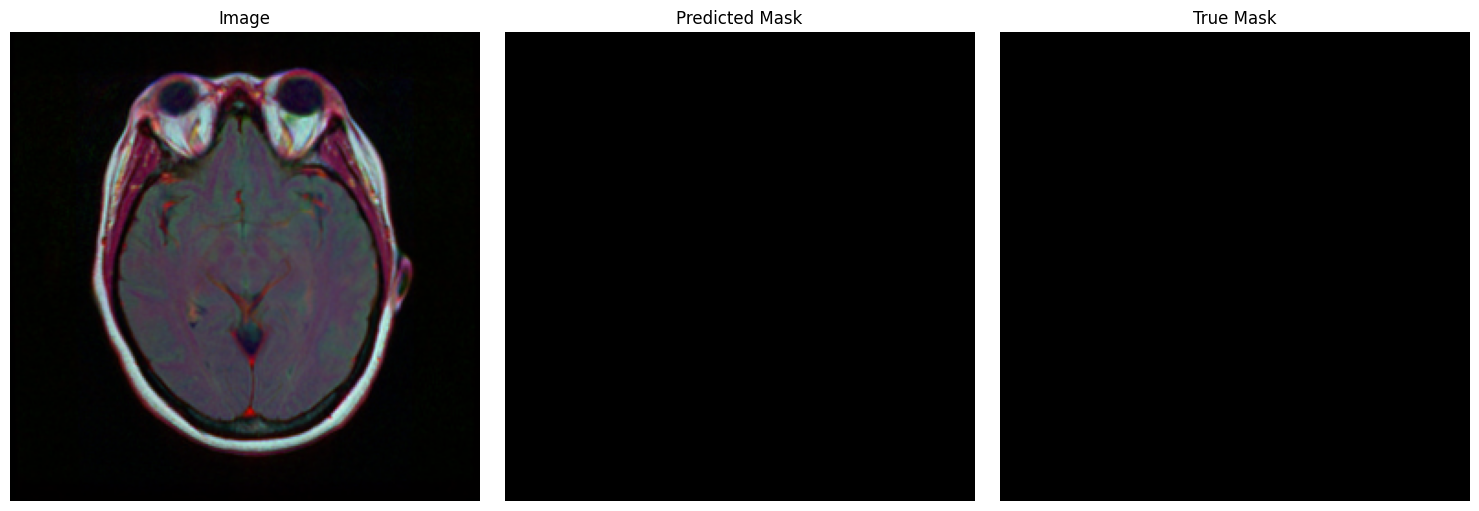

iou: 0.0
dice: nan


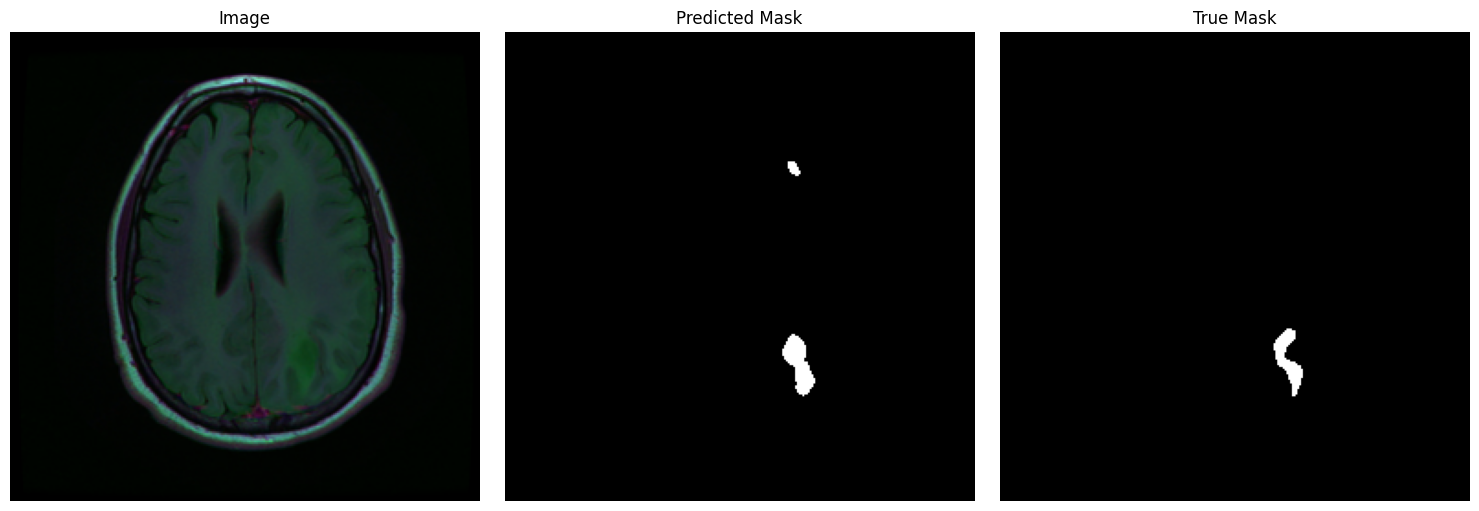

iou: 0.3863636255264282
dice: 0.5573770403862


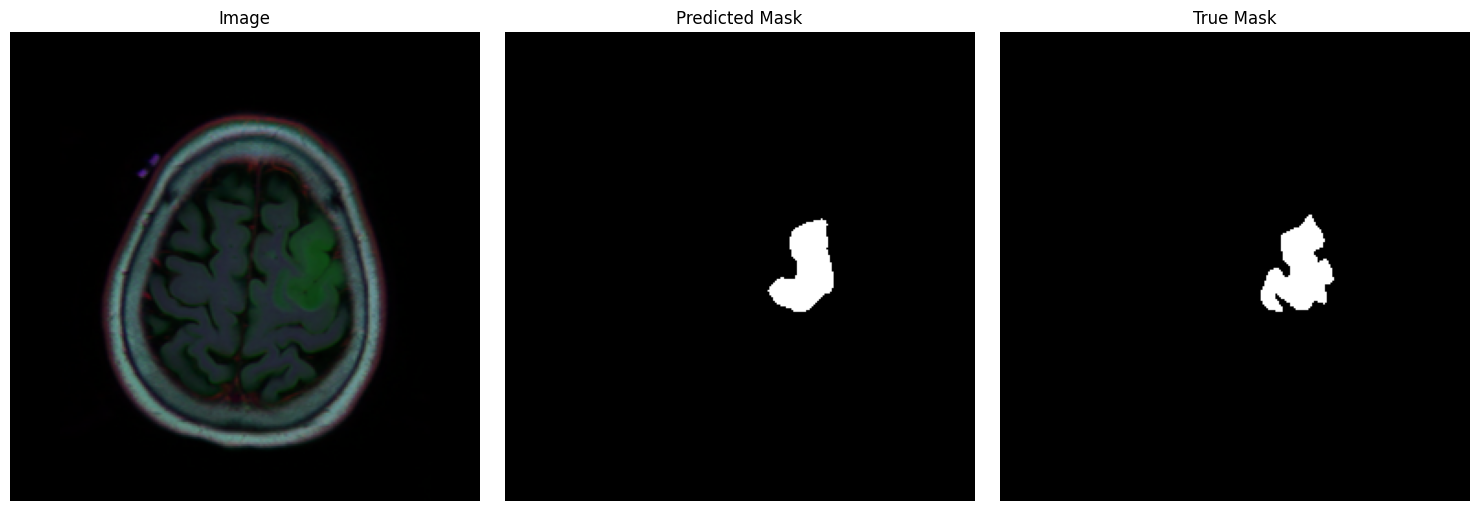

iou: 0.7400914430618286
dice: 0.8506351113319397


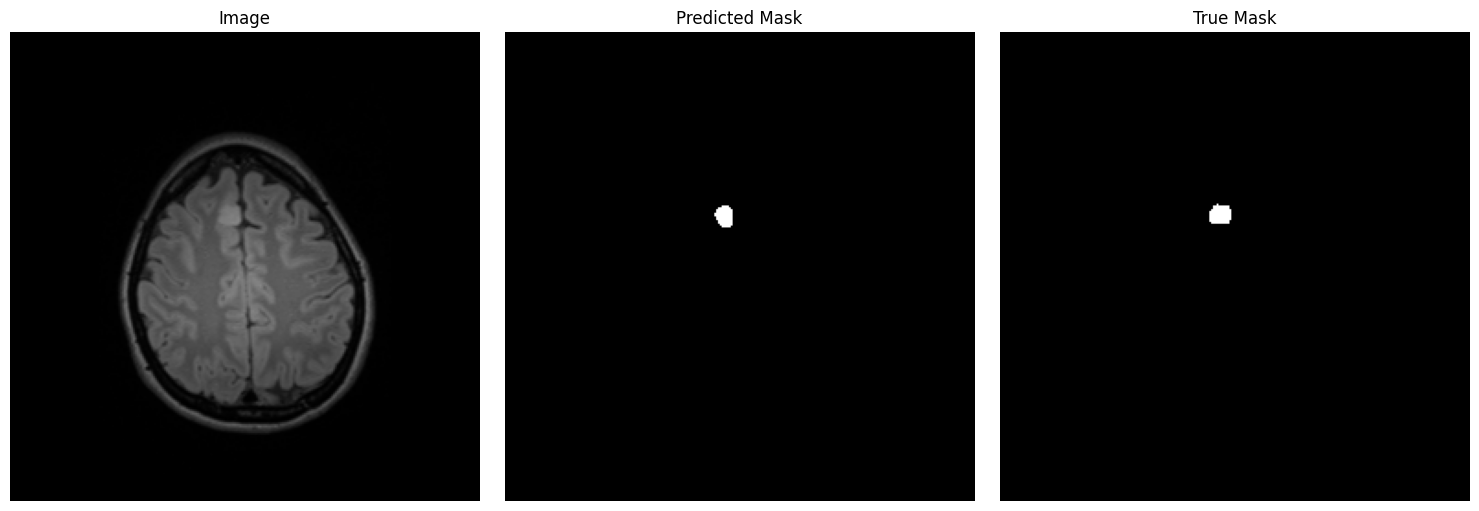

iou: 0.6747967600822449
dice: 0.8058252334594727


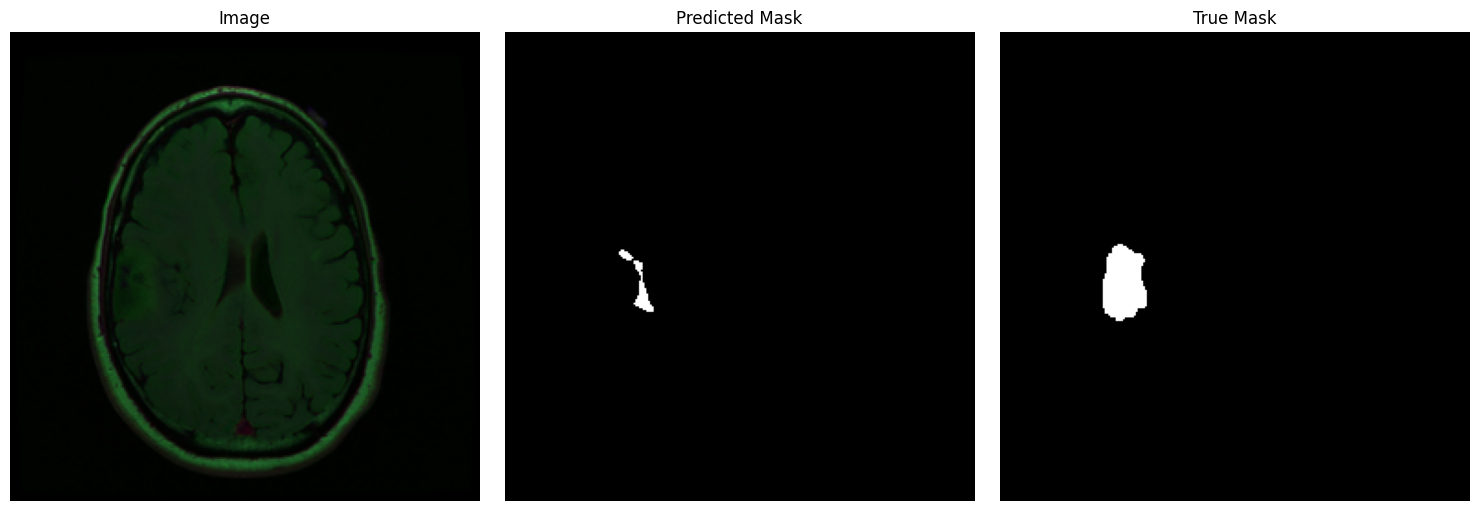

iou: 0.17193426191806793
dice: 0.29341962933540344


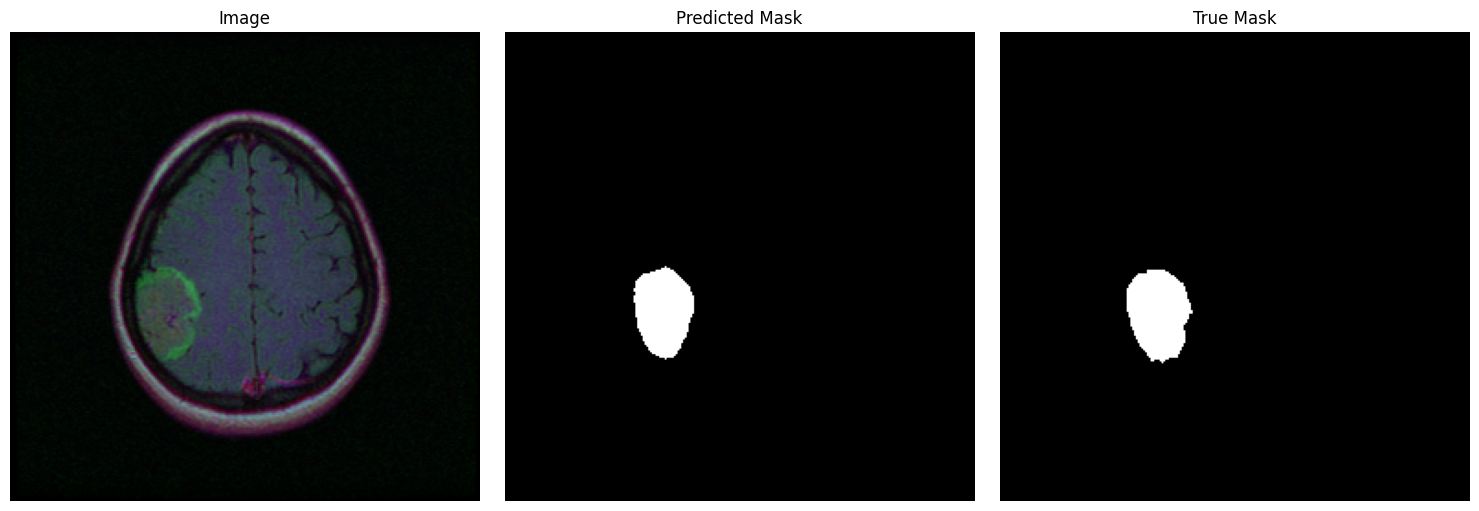

iou: 0.8967551589012146
dice: 0.9455676674842834


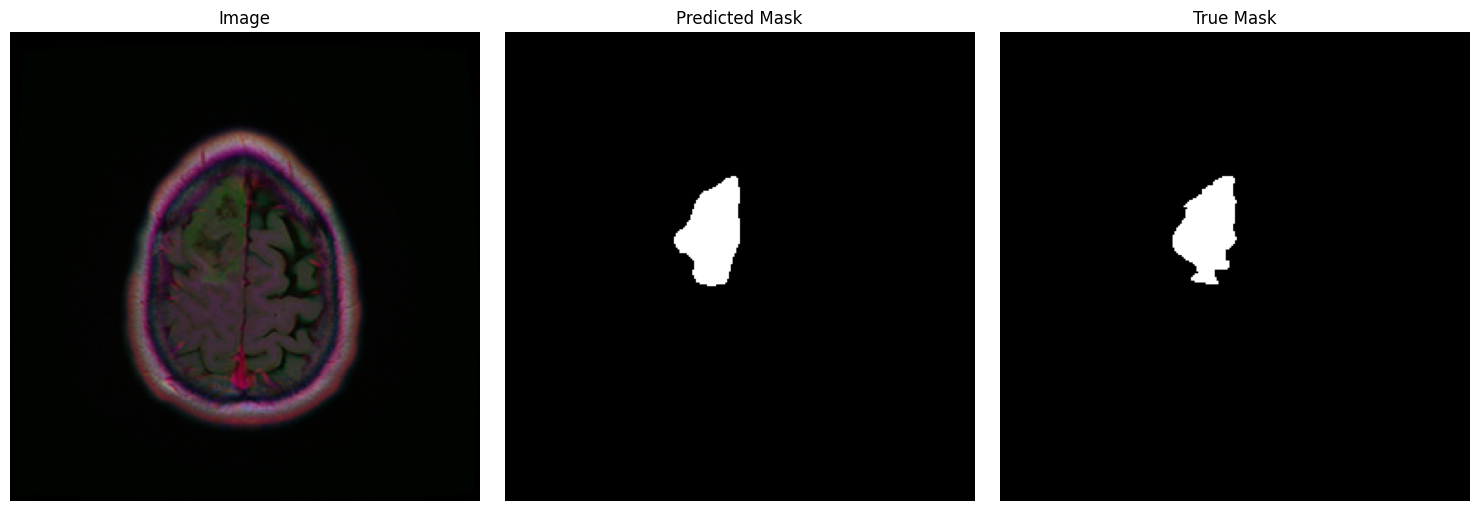

iou: 0.8773972392082214
dice: 0.9346953630447388


KeyboardInterrupt: 

In [11]:
total_iou = 0
total_dice_scrore = 0


with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device).float(), labels.to(device).float()

        preds = model(imgs)
        preds = torch.where(preds >= 0.5, 1., 0.)

        if (total_iou == 0):
            for k in range(20):
                visualize_sample(imgs[k], preds[k], labels[k])
                iou = calculate_iou(preds[k], labels[k])
                print(f'iou: {iou}')
                dice_score = calculate_dice_score(preds[k], labels[k])
                print(f'dice: {dice_score}')

        iou = calculate_iou(preds, labels)
        # print(f'iou: {iou}')
        total_iou += iou

        dice_score = calculate_dice_score(preds, labels)
        # print(f'dice: {dice_score}')
        total_dice_scrore += dice_score



test_iou = total_iou / len(test_dataloader)
test_dice_score = total_dice_scrore / len(test_dataloader)

print(f'IOU: {test_iou}')
print(f'Dice: {test_dice_score}')